In [7]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow.keras as k
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os 
from glob import glob
from tqdm import tqdm

import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics
from tensorflow.keras import Input, Model

##Downloading datasets from kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 707M/714M [00:04<00:00, 173MB/s]
100% 714M/714M [00:04<00:00, 163MB/s]


##Unziping 

In [4]:
import zipfile
zip=zipfile.ZipFile('/content/lgg-mri-segmentation.zip')
zip.extractall('/content')
zip.close()

In [5]:
%%time
# root = '/content/drive/MyDrive/Brain_Tumor/kaggle_3m'

root = '/content/kaggle_3m'

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 14.5 µs


In [8]:
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|██████████| 3929/3929 [00:01<00:00, 2554.16it/s]


##Ploting images

In [9]:
def plot_image(image, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image[..., 0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(mask[..., 0],cmap='gray')
    ax[1].axis('off')
    plt.show()

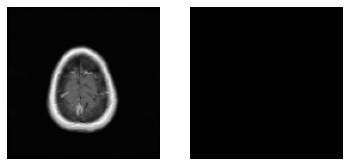

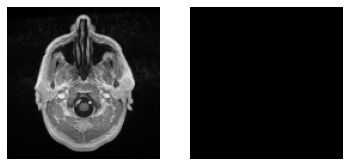

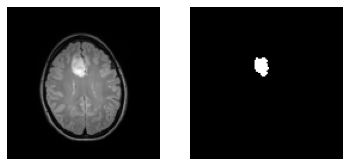

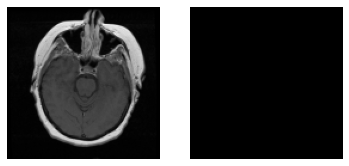

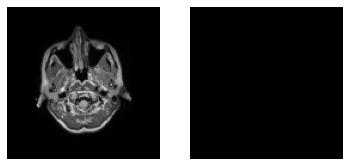

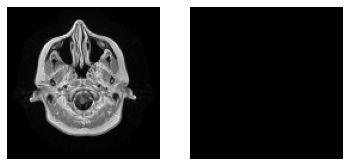

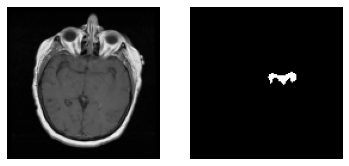

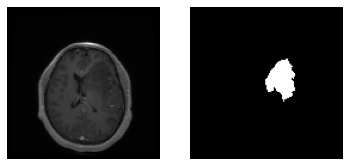

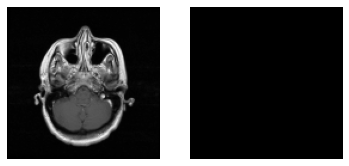

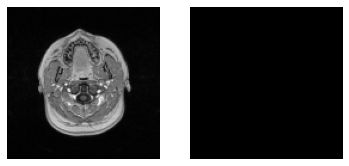

In [10]:
l = [random.randint(0,1000) for _ in range(10)]
for i in l:
  plot_image(images[i], masks[i])

In [11]:
instance = []
for i in range(masks.shape[0]):
    
    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')

In [12]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
       images_pos.append(images[i])
       masks_pos.append(masks[i])
        
images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Number of images  ',images_pos.shape)
print('Number of mask ',masks_pos.shape)

Number of images   (1373, 128, 128, 3)
Number of mask  (1373, 128, 128, 1)


##Splitting the datasets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .25, random_state = 288)

In [14]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_test shape:   (344, 128, 128, 3)


########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_test shape:   (344, 128, 128, 1)


In [15]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [16]:
#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

In [17]:
#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath

In [18]:
#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [19]:
#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock

#Attention U-NET model

In [26]:
#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model 

In [27]:
model=attentionunet(input_shape=(128,128,3))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 128, 128, 16  64         ['conv2d_96[0][0]']              
 ormalization)                  )                                                           

In [28]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history_1 = model.fit(X_train,y_train,verbose = 1,epochs = 10)

Epoch 1/10
33/33 [==============================] - 327s 9s/step - loss: 0.7012 - accuracy: 0.6416
Epoch 2/10
33/33 [==============================] - 306s 9s/step - loss: 0.6209 - accuracy: 0.9262
Epoch 3/10
33/33 [==============================] - 309s 9s/step - loss: 0.5933 - accuracy: 0.9580
Epoch 4/10
33/33 [==============================] - 300s 9s/step - loss: 0.5735 - accuracy: 0.9694
Epoch 5/10
33/33 [==============================] - 300s 9s/step - loss: 0.5560 - accuracy: 0.9748
Epoch 6/10
33/33 [==============================] - 292s 9s/step - loss: 0.5412 - accuracy: 0.9766
Epoch 7/10
33/33 [==============================] - 304s 9s/step - loss: 0.5257 - accuracy: 0.9794
Epoch 8/10
33/33 [==============================] - 295s 9s/step - loss: 0.5094 - accuracy: 0.9822
Epoch 9/10
33/33 [==============================] - 298s 9s/step - loss: 0.4967 - accuracy: 0.9826
Epoch 10/10
33/33 [==============================] - 298s 9s/step - loss: 0.4834 - accuracy: 0.9837


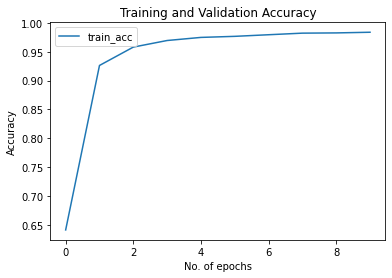

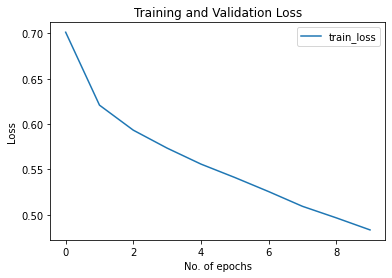

In [30]:
plt.plot(history_1.history['accuracy'] , label = 'train_acc')
#plt.plot(history_1.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history_1.history['loss'] , label = 'train_loss')
#plt.plot(history_1.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [31]:
model.save("att-unet_BrainTumor.h5")

In [32]:
model.load_weights("/content/att-unet_BrainTumor.h5")

In [33]:
y_pred = model.predict(X_test)

11/11 [==============================] - 26s 2s/step


Text(0.5, 1.0, 'Predicted')

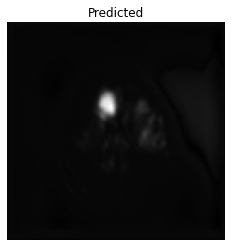

In [34]:
plt.imshow(y_pred[5,:,:].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Predicted")

Text(0.5, 1.0, 'Predicted')

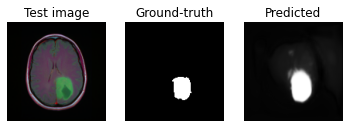

In [35]:
pred = np.reshape(y_pred,(344,128,128))

fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
plt.imshow(X_test[0, :, :])
plt.axis('off')
plt.title("Test image")

ax=fig.add_subplot(1,3,2)
plt.imshow(y_test[0].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
plt.imshow(pred[0],cmap='gray')
plt.axis('off')
plt.title("Predicted")

Text(0.5, 1.0, 'Predicted')

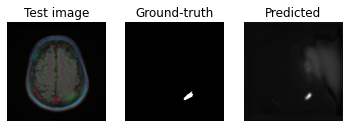

In [39]:
pred = np.reshape(y_pred,(344,128,128))

fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
plt.imshow(X_test[4, :, :])
plt.axis('off')
plt.title("Test image")

ax=fig.add_subplot(1,3,2)
plt.imshow(y_test[4,:,:].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
plt.imshow(pred[4],cmap='gray')
plt.axis('off')
plt.title("Predicted")

##Evaluation of performance

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


SCORE=[]
""" Calculating metrics values """
acc_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
f1_value =mean_squared_error(y_test.ravel(), y_pred.ravel())
jac_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
recall_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
precision_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
SCORE.append([acc_value, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[0:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

""" Saving all the results """
df = pd.DataFrame(SCORE, columns=["Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("score.csv")

Accuracy: 0.40559
F1: 0.17152
Jaccard: 0.40559
Recall: 0.40559
Precision: 0.40559


#RA-UNET MOdel

In [50]:
#Residual-Attention UNET (RA-UNET)
def residual_attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    
    
    # Downsampling layers
    dn_1 = res_conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = res_conv_block(pool1, kernelsize, filters[1], dropout, batchnorm)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = res_conv_block(pool2, kernelsize, filters[2], dropout, batchnorm)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = res_conv_block(pool3, kernelsize, filters[3], dropout, batchnorm)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = res_conv_block(pool4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = res_conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = res_conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = res_conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = res_conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary() 
    return model

In [ ]:
model2=residual_attentionunet(input_shape=(128,128,3))

In [54]:
model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
history_1 = model2.fit(X_train,y_train,verbose = 1,epochs = 10)

Epoch 1/10
33/33 [==============================] - 349s 11s/step - loss: 0.6303 - accuracy: 0.8686
Epoch 2/10
33/33 [==============================] - 343s 10s/step - loss: 0.5966 - accuracy: 0.9559
Epoch 3/10
33/33 [==============================] - 341s 10s/step - loss: 0.5791 - accuracy: 0.9737
Epoch 4/10
33/33 [==============================] - 339s 10s/step - loss: 0.5604 - accuracy: 0.9792
Epoch 5/10
33/33 [==============================] - 339s 10s/step - loss: 0.5418 - accuracy: 0.9813
Epoch 6/10
33/33 [==============================] - 338s 10s/step - loss: 0.5261 - accuracy: 0.9843
Epoch 7/10
33/33 [==============================] - 346s 10s/step - loss: 0.5119 - accuracy: 0.9847
Epoch 8/10
33/33 [==============================] - 345s 10s/step - loss: 0.4992 - accuracy: 0.9860
Epoch 9/10
33/33 [==============================] - 347s 11s/step - loss: 0.4833 - accuracy: 0.9876
Epoch 10/10
33/33 [==============================] - 345s 10s/step - loss: 0.4695 - accuracy: 0.9885

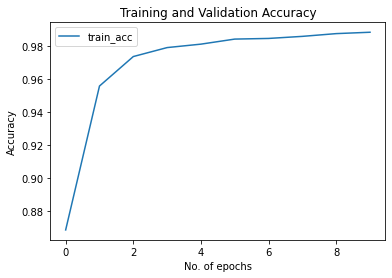

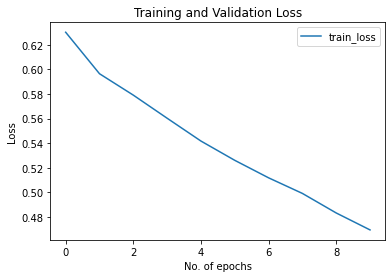

In [57]:
plt.plot(history_1.history['accuracy'] , label = 'train_acc')
#plt.plot(history_1.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history_1.history['loss'] , label = 'train_loss')
#plt.plot(history_1.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [60]:
model2.save("ra-unet_BrainTumor.h5")

In [62]:
y_pred = model2.predict(X_test)

11/11 [==============================] - 26s 2s/step


Text(0.5, 1.0, 'Predicted')

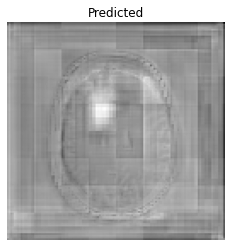

In [64]:
plt.imshow(y_pred[3,:,:].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Predicted")

Text(0.5, 1.0, 'Predicted')

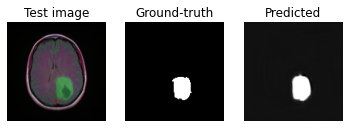

In [65]:
pred = np.reshape(y_pred,(344,128,128))

fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
plt.imshow(X_test[0, :, :])
plt.axis('off')
plt.title("Test image")

ax=fig.add_subplot(1,3,2)
plt.imshow(y_test[0].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
plt.imshow(pred[0],cmap='gray')
plt.axis('off')
plt.title("Predicted")

Text(0.5, 1.0, 'Predicted')

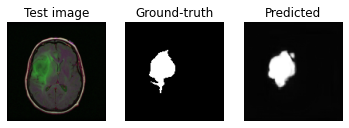

In [67]:
pred = np.reshape(y_pred,(344,128,128))

fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
plt.imshow(X_test[6, :, :])
plt.axis('off')
plt.title("Test image")

ax=fig.add_subplot(1,3,2)
plt.imshow(y_test[6,:,:].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
plt.imshow(pred[6],cmap='gray')
plt.axis('off')
plt.title("Predicted")

In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


SCORE=[]
""" Calculating metrics values """
acc_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
f1_value =mean_squared_error(y_test.ravel(), y_pred.ravel())
jac_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
recall_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
precision_value = mean_absolute_error(y_test.ravel(), y_pred.ravel())
SCORE.append([acc_value, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[0:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

Accuracy: 0.38155
F1: 0.14836
Jaccard: 0.38155
Recall: 0.38155
Precision: 0.38155
